# Features encoding
Here we would encode all the features that need to be feed into the model. 
There are three types of features:
1. Historical information:<br>
1.1 Number of flights delayed at the same hour a day before target flight's departure.<br>
1.2 Probailty of delay for given carrier calculated from the carrier;s past performace.<br>
1.3 Probailty of delay for a given destination calcukated from historical delay in flight departure going to that particular destination<br>
1.4 Percentage of flight delayed in 3 hours time window four hour prior to shceduled flight departure<br>
2. Weather information:<br>
temperature, dew point, humidity, wind, wind speed, wind gust speed, pressure, precipitation and condition.
3. Predetermined information:<br> Hour, Day and Month of the flight's scheduled departure.



In [1]:
import pandas as pd
import imblearn
import datetime
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
import glob

import os
from scipy.interpolate import interp1d
import seaborn as sns
sns.set_style("whitegrid")
from datetime import datetime, timedelta

## We are importing the data file which has information about all the flights deaprted from JFK from January 2018 to August 2022. For each flight, corrosponding weather information for that hour has been augmented.

In [2]:

merged_df=pd.read_csv("Merged18_22_df.csv")
merged_df.drop(["Unnamed: 0","Unnamed: 0.1"],axis=1,inplace=True)
merged_df.describe()
merged_df.Actual_Dep_Time = pd.to_datetime(merged_df.Actual_Dep_Time)
merged_df.Scheduled_Dep_Time = pd.to_datetime(merged_df.Scheduled_Dep_Time)
merged_df= merged_df.set_index('Scheduled_Dep_Time')
merged_df.drop(["Unnamed: 0.1.1"],axis=1,inplace=True)
merged_df.columns

Index(['Actual_Dep_Time', 'DayOfWeek', 'FL_Date', 'Carrier', 'FL_Num',
       'Origin', 'Dest', 'DepDelay', 'DepartureDelayGroups', 'TaxiOut',
       'Scheduled_Arr_Time', 'Actual_Arr_Time', 'ArrDelay',
       'ArrivalDelayGroups', 'Cancelled', 'CancellationCode', 'Diverted',
       'Estimated_Elapsed_Time', 'Actual_Elapsed_Time', 'Distance',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Month', 'Hour',
       'Day', 'Year', 'Temperature_F', 'Dew_Point_F', 'Humidity_%', 'Wind',
       'Wind_Speed_mph', 'Wind_Gust_mph', 'Pressure_in', 'Precip_in',
       'Condition'],
      dtype='object')

# Calculating the probabilty of carrier dependent delay

Probabilty of delay for the carrier $C_i$ for the month $m_j$ in the current year is approximated from the $C_i$'s delay in the month $m_{j-1}$. However instead of using the $C_i$'s delay in the month $m_{j-1}$, $P(C_i,m_{j-1})$, as $P(C_i,m_{j})$,  $P(C_i,m_{j-1})$ is scaled by a scaling factor $s$ which encompases the monthly changes in the trend of average delay in the whole 4 year dataset.
$P(C_i,m_{j1}$)=$P(C_i,m_{j-1})$*s


In [3]:
Aug_22=merged_df['2022-08-01':'2022-08-31']  # Test set
merged_df=merged_df['2018-01-01':'2022-07-31'] 

C:\Users\lalit\AppData\Local\Temp/ipykernel_20020/3905385841.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  Aug_22=merged_df['2022-08-01':'2022-08-31']  # Test set
C:\Users\lalit\AppData\Local\Temp/ipykernel_20020/3905385841.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  merged_df=merged_df['2018-01-01':'2022-07-31']


In [4]:
merged_df

,Actual_Dep_Time,DayOfWeek,FL_Date,Carrier,FL_Num,Origin,Dest,DepDelay,DepartureDelayGroups,TaxiOut,...,Year,Temperature_F,Dew_Point_F,Humidity_%,Wind,Wind_Speed_mph,Wind_Gust_mph,Pressure_in,Precip_in,Condition
Scheduled_Dep_Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 22:52:00,2018-01-01 00:12:00,1,2018-01-01,B6,1816,JFK,SYR,80.0,5.0,13.0,...,2018,9.0,-3.0,59.0,NNW,18.0,0.0,30.33,0.0,Fair
2018-01-01 22:46:00,2018-01-01 02:38:00,1,2018-01-01,B6,718,JFK,BOS,232.0,12.0,13.0,...,2018,8.0,-4.0,58.0,NNW,14.0,0.0,30.34,0.0,Fair
2018-01-01 05:30:00,2018-01-01 05:21:00,1,2018-01-01,B6,353,JFK,PBI,-9.0,-1.0,20.0,...,2018,7.0,-5.0,58.0,NW,17.0,0.0,30.34,0.0,Fair
2018-01-01 05:45:00,2018-01-01 05:42:00,1,2018-01-01,B6,601,JFK,FLL,-3.0,-1.0,18.0,...,2018,7.0,-5.0,58.0,NW,16.0,0.0,30.35,0.0,Fair
2018-01-01 06:00:00,2018-01-01 05:54:00,1,2018-01-01,AA,1468,JFK,PHX,-6.0,-1.0,14.0,...,2018,7.0,-5.0,58.0,NW,16.0,0.0,30.35,0.0,Fair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 22:00:00,2022-07-31 23:20:00,7,2022-07-31,YX,4691,JFK,RIC,80.0,5.0,25.0,...,2022,75.0,68.0,79.0,SSW,10.0,0.0,30.05,0.0,Light Rain
2022-07-31 22:55:00,2022-07-31 23:24:00,7,2022-07-31,B6,1318,JFK,BOS,29.0,1.0,18.0,...,2022,75.0,59.0,57.0,NE,5.0,0.0,30.14,0.0,Fair
2022-07-31 22:45:00,2022-07-31 23:26:00,7,2022-07-31,B6,2923,JFK,LAX,41.0,2.0,20.0,...,2022,75.0,59.0,57.0,NE,5.0,0.0,30.14,0.0,Fair


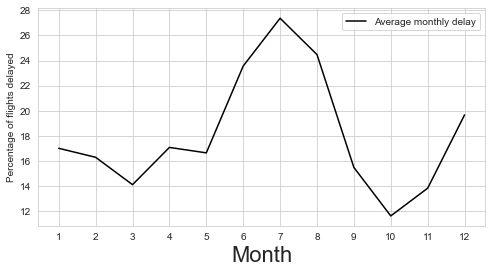

In [5]:
df=merged_df[merged_df['DepDelay']>15]
Delay=df[["DepDelay","Month"]].groupby("Month").count()
df=merged_df.copy()
Total_flight_Count=df[["DepDelay","Month"]].groupby("Month").count()

plt.figure(figsize=(8,4))
x=np.arange(len(Delay.index))+1 # month axis
y=Delay.DepDelay/Total_flight_Count.DepDelay*100 # percentage of flights delayed aggregated month wise
plt.plot(x,y,color='k',label="Average monthly delay")
plt.ylabel("Percentage of flights delayed")
plt.xlabel("Month", fontsize=22)
plt.xticks(x,Delay.index)
global_delay_function = interp1d(range(1,13), y, kind='quadratic')
xnew=np.arange(1,12,.1)
plt.legend()
plt.show()

In [6]:
avg_delay_dictionary={}
for carrier in  merged_df.Carrier.unique():
    for year in merged_df.Year.unique():
        df=merged_df[merged_df['DepDelay']>15]
        temp=df[["DepDelay","Carrier","Month","Year"]]
        temp=temp[temp["Carrier"]==carrier]
        temp=temp[temp["Year"]==year].groupby("Month").count()
        Delay=temp.copy()
        df=merged_df.copy()
        temp=df[["DepDelay","Carrier","Month","Year"]]
        temp=temp[temp["Carrier"]==carrier]
        temp=temp[temp["Year"]==year].groupby("Month").count()
        Total_flight_Count=temp.copy()
        
        x=np.arange(len(Total_flight_Count.index))+1
        y=(Delay.DepDelay/Total_flight_Count.DepDelay).values
#         plt.bar(x,Delay.DepDelay/Total_flight_Count.DepDelay*100,width=0.15,alpha=1,color='r',label=str(year))# color=['red', 'blue', 'magenta', 'green', 'pink'])
#         plt.ylabel("Percentage of flights delayed")
#         plt.xlabel("Month")
#         plt.xticks(rotation=90, ha='center',size=14,fontweight='bold')
#         plt.title(carrier)
#         plt.ylim(0,50)
#         plt.legend()
        for i in range(len(x)):            
            avg_delay_dictionary[(carrier,year,x[i])]=y[i]



In [7]:
interpolated_avg_delay_dictionary={}
for key in avg_delay_dictionary.keys():
    car,year,month=key
    if year==2018 and month ==1:
        interpolated_avg_delay_dictionary[key]=avg_delay_dictionary[key]
    elif  month ==1:
        prev_month_key=(key[0],key[1]-1,12)   # previous year december
      
        scaling_factor=global_delay_function(key[2])/global_delay_function(12)
        if  avg_delay_dictionary.get(prev_month_key) :
            interpolated_avg_delay_dictionary[key]=avg_delay_dictionary[prev_month_key]*scaling_factor
        else : 
            interpolated_avg_delay_dictionary[key]=avg_delay_dictionary[key]
            print(key)
            
    else : 
        prev_month_key=(key[0],key[1],key[2]-1)   # previous month
        scaling_factor=global_delay_function(key[2])/global_delay_function(key[2]-1)
        if  avg_delay_dictionary.get(prev_month_key) :
            interpolated_avg_delay_dictionary[key]=  avg_delay_dictionary[prev_month_key]*scaling_factor
        else :
            interpolated_avg_delay_dictionary[key]=avg_delay_dictionary[key]
            print(key)
   

('9E', 2019, 1)
('HA', 2021, 1)
('YX', 2019, 1)
('MQ', 2019, 1)
('OO', 2019, 1)
('OH', 2019, 1)
('UA', 2021, 1)
('UA', 2022, 1)


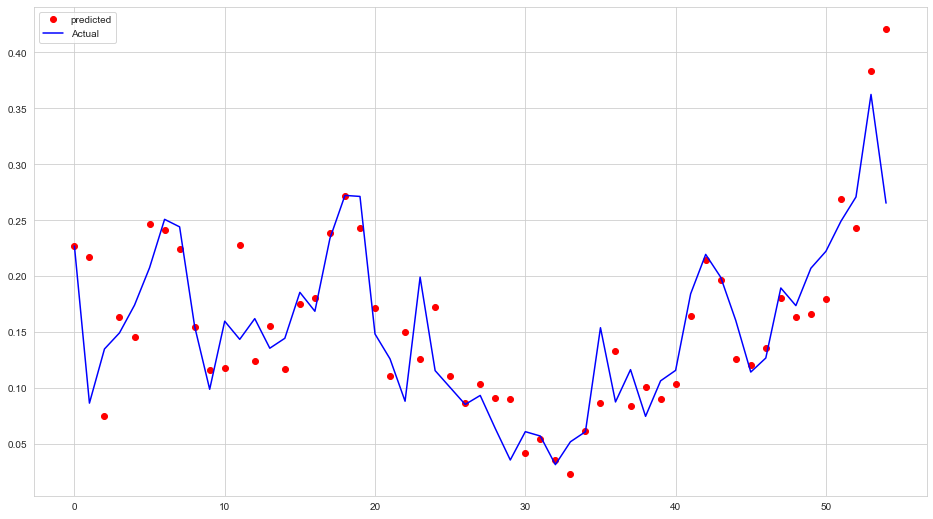

In [8]:
actual,predicted_delay=[],[]
for key in interpolated_avg_delay_dictionary:
    car="DL"
    if key[0]==car:
#         print(("AA",key[1],key[2]))
        predicted_delay.append( interpolated_avg_delay_dictionary[(car,key[1],key[2])])
        actual.append( avg_delay_dictionary[(car,key[1],key[2])])

plt.figure(figsize=(16,9))
plt.plot(range(len(predicted_delay)),predicted_delay,"ro",label="predicted")
plt.plot(range(len(actual)),actual,'b-',label="Actual")
plt.legend()
# plt.xlim(0,4)


In [9]:
Carrier_delay_probabilty=[]
for c,y,m in zip(df.Carrier.values,df.Year.values,df.Month.values):
   
    Carrier_delay_probabilty.append(interpolated_avg_delay_dictionary.get((c,y,m)))
Feature_df=merged_df.copy()
Feature_df["Carrier_delay_probabilty"]=Carrier_delay_probabilty

Next, we are calculating the probabilty for delay for each destination based on the historical month wise aggregation

In [10]:
    
avg_destination_delay_dictionary={}
for dest in  merged_df.Dest.unique():
        df=merged_df[merged_df['DepDelay']>15]
        temp=df[["DepDelay","Dest","Month","Year"]]
        temp=temp[temp["Dest"]==dest]
        temp=temp.groupby("Month").count()
        Delay=temp.copy()
        df=merged_df.copy()
        temp=df[["DepDelay","Dest","Month","Year"]]
        temp=temp[temp["Dest"]==dest]
        temp=temp.groupby("Month").count()
        Total_flight_Count=temp.copy()
        
        x=np.arange(len(Total_flight_Count.index))+1
        y=(Delay.DepDelay/Total_flight_Count.DepDelay).values

        for i in range(len(x)):            
            avg_destination_delay_dictionary[(dest,x[i])]=y[i]
Destination_delay_probabilty=[]
for c,m in zip(merged_df.Dest.values,merged_df.Month.values):
    Destination_delay_probabilty.append(avg_destination_delay_dictionary.get((c,m)))
# Feature_df=merged_df.copy()
Feature_df["Destination_delay_probabilty"]=Destination_delay_probabilty

In [11]:
Feature_df.loc[Feature_df['DepDelay'] >=15, 'Label'] = 1
Feature_df.loc[Feature_df['DepDelay'] <15, 'Label'] = 0
Feature_df

,Actual_Dep_Time,DayOfWeek,FL_Date,Carrier,FL_Num,Origin,Dest,DepDelay,DepartureDelayGroups,TaxiOut,...,Humidity_%,Wind,Wind_Speed_mph,Wind_Gust_mph,Pressure_in,Precip_in,Condition,Carrier_delay_probabilty,Destination_delay_probabilty,Label
Scheduled_Dep_Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 22:52:00,2018-01-01 00:12:00,1,2018-01-01,B6,1816,JFK,SYR,80.0,5.0,13.0,...,59.0,NNW,18.0,0.0,30.33,0.0,Fair,0.270596,0.230769,1.0
2018-01-01 22:46:00,2018-01-01 02:38:00,1,2018-01-01,B6,718,JFK,BOS,232.0,12.0,13.0,...,58.0,NNW,14.0,0.0,30.34,0.0,Fair,0.270596,0.198739,1.0
2018-01-01 05:30:00,2018-01-01 05:21:00,1,2018-01-01,B6,353,JFK,PBI,-9.0,-1.0,20.0,...,58.0,NW,17.0,0.0,30.34,0.0,Fair,0.270596,0.222359,0.0
2018-01-01 05:45:00,2018-01-01 05:42:00,1,2018-01-01,B6,601,JFK,FLL,-3.0,-1.0,18.0,...,58.0,NW,16.0,0.0,30.35,0.0,Fair,0.270596,0.214052,0.0
2018-01-01 06:00:00,2018-01-01 05:54:00,1,2018-01-01,AA,1468,JFK,PHX,-6.0,-1.0,14.0,...,58.0,NW,16.0,0.0,30.35,0.0,Fair,0.164458,0.145299,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 22:00:00,2022-07-31 23:20:00,7,2022-07-31,YX,4691,JFK,RIC,80.0,5.0,25.0,...,79.0,SSW,10.0,0.0,30.05,0.0,Light Rain,0.259734,0.179567,1.0
2022-07-31 22:55:00,2022-07-31 23:24:00,7,2022-07-31,B6,1318,JFK,BOS,29.0,1.0,18.0,...,57.0,NE,5.0,0.0,30.14,0.0,Fair,0.517304,0.299375,1.0
2022-07-31 22:45:00,2022-07-31 23:26:00,7,2022-07-31,B6,2923,JFK,LAX,41.0,2.0,20.0,...,57.0,NE,5.0,0.0,30.14,0.0,Fair,0.517304,0.219452,1.0


Now, we are interested in calculating what percentage of flights are delayed 4 hours before the scheduled departure of target flight. 

In [12]:

Feature_df.sort_index(inplace=True)
merged_df2=Feature_df.copy()
Dep_Delay_Series=merged_df2.Label
merged_df2["Delaym4h"]=Dep_Delay_Series.rolling('1H').sum()

print(merged_df2["Delaym4h"].isna().sum() )
Delay_df=merged_df2.copy()[["Delaym4h"]]
Delay_df.index=Delay_df.index-timedelta(hours=-4)
Delay_df=Delay_df.rename(columns={"Delaym4h": "Delaym4h_s"})
tol=tol = pd.Timedelta('360 minute')
Feature_df2 = pd.merge_asof(merged_df2, Delay_df,
                       right_index=True,left_index=True,direction='nearest',tolerance=tol)
#                      
                     

display(Feature_df2)

0


,Actual_Dep_Time,DayOfWeek,FL_Date,Carrier,FL_Num,Origin,Dest,DepDelay,DepartureDelayGroups,TaxiOut,...,Wind_Speed_mph,Wind_Gust_mph,Pressure_in,Precip_in,Condition,Carrier_delay_probabilty,Destination_delay_probabilty,Label,Delaym4h,Delaym4h_s
Scheduled_Dep_Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 05:30:00,2018-01-01 05:21:00,1,2018-01-01,B6,353,JFK,PBI,-9.0,-1.0,20.0,...,17.0,0.0,30.34,0.0,Fair,0.270596,0.222359,0.0,0.0,0.0
2018-01-01 05:30:00,2018-01-01 06:37:00,1,2018-01-01,B6,939,JFK,BQN,67.0,4.0,21.0,...,21.0,0.0,30.36,0.0,Fair / Windy,0.270596,0.291925,1.0,1.0,0.0
2018-01-01 05:45:00,2018-01-01 05:42:00,1,2018-01-01,B6,601,JFK,FLL,-3.0,-1.0,18.0,...,16.0,0.0,30.35,0.0,Fair,0.270596,0.214052,0.0,1.0,0.0
2018-01-01 05:50:00,2018-01-01 07:13:00,1,2018-01-01,B6,318,JFK,BOS,83.0,5.0,17.0,...,21.0,0.0,30.36,0.0,Fair / Windy,0.270596,0.198739,1.0,2.0,0.0
2018-01-01 06:00:00,2018-01-01 07:43:00,1,2018-01-01,B6,289,JFK,MCO,103.0,6.0,18.0,...,18.0,0.0,30.37,0.0,Fair,0.270596,0.186808,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 22:50:00,2022-07-31 22:49:00,7,2022-07-31,9E,4988,JFK,BWI,-1.0,-1.0,25.0,...,10.0,0.0,30.05,0.0,Light Rain,0.207507,0.254032,0.0,10.0,9.0
2022-07-31 22:55:00,2022-07-31 23:24:00,7,2022-07-31,B6,1318,JFK,BOS,29.0,1.0,18.0,...,5.0,0.0,30.14,0.0,Fair,0.517304,0.299375,1.0,11.0,9.0
2022-07-31 22:59:00,2022-07-31 22:43:00,7,2022-07-31,9E,4959,JFK,BGR,-16.0,-2.0,24.0,...,10.0,0.0,30.05,0.0,Light Rain,0.207507,0.094340,0.0,9.0,8.0


Now we are calculating the percentage of flights delayed, in one hour window,  24 hours before the schedulded departure of target flight. 

In [13]:
avg_historic_hour_delay_dictionary={}
cols=['DayOfWeek','DepDelay','Month', 'Hour','Year','Day',"Label"]

for year in  Feature_df2.Year.unique():
    for month in Feature_df2.Month.unique():
        df=Feature_df2[cols].copy()
        df=df[df.Year==year]
        df=df[df.Month==month]

        df["date_hour"]=df.index.round('H')

        df_grouped=df[['DayOfWeek','DepDelay','Month',"Day" ,'Hour','Year',"date_hour","Label"]].groupby("date_hour").sum()
        
        z_delayed=df_grouped.Label
        day=df_grouped.index.day
        hour=df_grouped.index.hour
#         df=Feature_df2[cols].copy()
        df_grouped=df[['DayOfWeek','DepDelay','Month',"Day" ,'Hour','Year',"date_hour","Label"]].groupby("date_hour").count()
       
        z_total=df_grouped.Label
        z_probabilty=z_delayed/z_total
       
        for i in range(len(z_probabilty)):            
            avg_historic_hour_delay_dictionary[(year,month,day[i],hour[i])]=z_probabilty[i]
      
        
Yesterday_delay_probabilty=[]      
        
for y,m,d,h in zip(Feature_df2.index.year,Feature_df2.index.month,Feature_df2.index.day,Feature_df2.index.hour):
    Yesterday_delay_probabilty.append(avg_historic_hour_delay_dictionary.get((y,m,d-1,h)))
# Feature_df=merged_df.copy()
Feature_df2["Yesterday_delay_probabilty"]=Yesterday_delay_probabilty

In [14]:
Feature_df2.columns

Index(['Actual_Dep_Time', 'DayOfWeek', 'FL_Date', 'Carrier', 'FL_Num',
       'Origin', 'Dest', 'DepDelay', 'DepartureDelayGroups', 'TaxiOut',
       'Scheduled_Arr_Time', 'Actual_Arr_Time', 'ArrDelay',
       'ArrivalDelayGroups', 'Cancelled', 'CancellationCode', 'Diverted',
       'Estimated_Elapsed_Time', 'Actual_Elapsed_Time', 'Distance',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Month', 'Hour',
       'Day', 'Year', 'Temperature_F', 'Dew_Point_F', 'Humidity_%', 'Wind',
       'Wind_Speed_mph', 'Wind_Gust_mph', 'Pressure_in', 'Precip_in',
       'Condition', 'Carrier_delay_probabilty', 'Destination_delay_probabilty',
       'Label', 'Delaym4h', 'Delaym4h_s', 'Yesterday_delay_probabilty'],
      dtype='object')

Now we have all the feature columns in the dataframe "Feature_df2". We still need scale the features amd encode them. For now we would save this data into csv file

In [15]:
columns=['DayOfWeek',"Month","Hour", 'Temperature_F', 'Dew_Point_F',
       'Humidity_%',  'Wind_Speed_mph', 'Wind_Gust_mph', 'Pressure_in',
       'Precip_in',"Wind","Condition",
        "Carrier_delay_probabilty","Destination_delay_probabilty", 
        "Delaym4h_s","Yesterday_delay_probabilty","DepDelay","Label"]
df_csv=Feature_df2[columns]
df_csv.to_csv("JFK_2018_2022_final_features_prior.csv")

In [16]:
df_csv

,DayOfWeek,Month,Hour,Temperature_F,Dew_Point_F,Humidity_%,Wind_Speed_mph,Wind_Gust_mph,Pressure_in,Precip_in,Wind,Condition,Carrier_delay_probabilty,Destination_delay_probabilty,Delaym4h_s,Yesterday_delay_probabilty,DepDelay,Label
Scheduled_Dep_Time,,,,,,,,,,,,,,,,,,
2018-01-01 05:30:00,1,1,5,7.0,-5.0,58.0,17.0,0.0,30.34,0.0,NW,Fair,0.270596,0.222359,0.0,NaN,-9.0,0.0
2018-01-01 05:30:00,1,1,5,7.0,-5.0,58.0,21.0,0.0,30.36,0.0,NW,Fair / Windy,0.270596,0.291925,0.0,NaN,67.0,1.0
2018-01-01 05:45:00,1,1,5,7.0,-5.0,58.0,16.0,0.0,30.35,0.0,NW,Fair,0.270596,0.214052,0.0,NaN,-3.0,0.0
2018-01-01 05:50:00,1,1,5,7.0,-5.0,58.0,21.0,0.0,30.36,0.0,NW,Fair / Windy,0.270596,0.198739,0.0,NaN,83.0,1.0
2018-01-01 06:00:00,1,1,6,8.0,-5.0,55.0,18.0,0.0,30.37,0.0,NW,Fair,0.270596,0.186808,0.0,NaN,103.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 22:50:00,7,7,22,75.0,68.0,79.0,10.0,0.0,30.05,0.0,SSW,Light Rain,0.207507,0.254032,9.0,0.217391,-1.0,0.0
2022-07-31 22:55:00,7,7,22,75.0,59.0,57.0,5.0,0.0,30.14,0.0,NE,Fair,0.517304,0.299375,9.0,0.217391,29.0,1.0
2022-07-31 22:59:00,7,7,22,75.0,68.0,79.0,10.0,0.0,30.05,0.0,SSW,Light Rain,0.207507,0.094340,8.0,0.217391,-16.0,0.0
